In [60]:
import os

from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_curve
)
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms

In [4]:
df = pd.read_excel('./project_train.xlsx')
df = df.fillna(0)
corr = df[FEATURE_COLUMNS].corr()
print(corr)
corr.to_excel('./train_corr.xlsx')

                 B   COM_RAT    Cyclic         D      Dcy*       DIT  \
B         1.000000 -0.079649 -0.077862  0.949534  0.072115 -0.021094   
COM_RAT  -0.079649  1.000000  0.371491 -0.136029  0.194926 -0.185669   
Cyclic   -0.077862  0.371491  1.000000 -0.159031  0.471428 -0.048793   
D         0.949534 -0.136029 -0.159031  1.000000  0.064286  0.016784   
Dcy*      0.072115  0.194926  0.471428  0.064286  1.000000  0.304261   
DIT      -0.021094 -0.185669 -0.048793  0.016784  0.304261  1.000000   
DPT*     -0.049545  0.245961  0.725074 -0.112133  0.149629 -0.194484   
E         0.958448 -0.046733 -0.022641  0.850430  0.042574 -0.037622   
INNER     0.204053 -0.195664 -0.298160  0.286254  0.159500  0.573214   
LCOM      0.329428  0.063240 -0.162739  0.310297 -0.067734 -0.124741   
Level    -0.151357  0.359927  0.758563 -0.249851  0.627880 -0.009210   
LOC       0.845559 -0.027157 -0.161820  0.837003  0.100741  0.011395   
N         0.903764 -0.113874 -0.149923  0.886971  0.089542  0.01

In [61]:
df = pd.read_excel('./data.xlsx')
print(df.columns)
_cat = df['metrics'].astype('category').cat
print(_cat.categories)
# print(_cat.codes)

Index(['testart', 'CC', 'MC', 'BC', 'LC', 'mio', 'CC-1', 'MC-1', 'BC-1',
       'LC-1', '1适合LLM', 'B', 'COM_RAT', 'Cyclic', 'D', 'Dcy*', 'DIT', 'DPT*',
       'E', 'Inner', 'LCOM', 'Level', 'LOC', 'N', 'NCLOC', 'NOAC', 'NOC',
       'NOIC', 'OCmax', 'PDcy', 'PDpt', 'STAT', 'SUB', 'TCOM_RAT', 'V', 'WMC',
       'CBO', 'CLOC', 'Command', 'CONS', 'CSA', 'CSO', 'CSOA', 'Dcy', 'DPT',
       'jf', 'JLOC', 'Jm', 'Level*', 'n', 'NAAC', 'NAIC', 'NOOC', 'NTP',
       'OCavg', 'OPavg', 'OSavg', 'OSmax', 'Query', 'RFC', 'TODO', 'MPC',
       'INNER', 'metrics', 'class'],
      dtype='object')
Index([' lang', 'cli', 'csv', 'datafaker', 'gson', 'jfreechart', 'ruler'], dtype='object')


In [50]:
key = 'CC'
df[key] = df[key].str.split('%', expand=True)[0]

In [62]:
FEATURE_COLUMNS = [
    # 'CC', 'MC', 'BC', 'LC', 'CC-1', 'MC-1', 'BC-1', 'LC-1', 
    'metrics', 'B', 'COM_RAT', 'Cyclic', 'D',
    'Dcy*', 'DIT', 'DPT*', 'E', 'Inner', 'LCOM', 'Level', 'LOC', 'N',
    'NCLOC', 'NOAC', 'NOC', 'NOIC', 'OCmax', 'PDcy', 'PDpt', 'STAT', 'SUB',
    'TCOM_RAT', 'V', 'WMC', 'CBO', 'CLOC', 'Command', 'CONS', 'CSA', 'CSO',
    'CSOA', 'Dcy', 'DPT', 'INNER', 'jf', 'JLOC', 'Jm', 'Level*', 'MPC', 'n',
    'NAAC', 'NAIC', 'NOOC', 'NTP', 'OCavg', 'OPavg', 'OSavg', 'OSmax',
    'Query', 'RFC', 'TODO'
]
# FEATURE_COLUMNS = [
#     "B","COM_RAT","Cyclic","D","Dcy*","DIT","DPT*","E","INNER",
#     "LCOM","Level","LOC","N","NCLOC","NOAC","NOC","NOIC","OCmax","PDcy","PDpt",
#     "STAT","SUB","TCOM_RAT","V","WMC"
# ]
LABEL_COLUMN = "1适合LLM"

def load_data(data_path, target_col=FEATURE_COLUMNS):
    df = pd.read_excel(data_path)
    for key in ['CC', 'MC', 'CC-1', 'MC-1']:
        df[key] = pd.to_numeric(df[key].str.split('%', expand=True)[0]) / 100
    for key in ['metrics']:
        _cat = df[key].astype('category').cat
        print(_cat.categories)
        df[key] = _cat.codes
    df_check = df.isnull().any(axis=1)
    print('NaN: ', df[df_check])
    df = df.fillna(-1)
    
    x = df[target_col].to_numpy()
    y = df[LABEL_COLUMN].to_numpy()
    return x, y

train_x, train_y = load_data('./data.xlsx')

# test_x, test_y = load_data('./project_test.xlsx')

scaler = StandardScaler()
scaler.fit(train_x)
print(scaler.mean_)
print(scaler.var_)

train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)

Index([' lang', 'cli', 'csv', 'datafaker', 'gson', 'jfreechart', 'ruler'], dtype='object')
NaN:                       testart   CC     MC     BC     LC  \
30             ToStringStyle  1.0  0.870  0.648  0.807   
31         AtomicInitializer  0.0  0.000  0.000  0.000   
32     AtomicSafeInitializer  0.0  0.000  0.000  0.000   
33     BackgroundInitializer  0.0  0.000  0.000  0.000   
40           LazyInitializer  0.0  0.000  0.000  0.000   
...                      ...  ...    ...    ...    ...   
1008  NormalizedMatrixSeries  1.0  0.667    NaN  0.467   
1012            VectorSeries  1.0  0.900    NaN  0.812   
1016         XIntervalSeries  1.0  1.000    NaN  1.000   
1024        XYIntervalSeries  1.0  1.000    NaN  1.000   
1031         YIntervalSeries  1.0  1.000    NaN  1.000   

                         mio  CC-1   MC-1   BC-1   LC-1  ...     OPavg  \
30             ToStringStyle   1.0  0.959  0.818  0.905  ...  1.910714   
31         AtomicInitializer   0.0  0.000  0.000  0.000  .

Index([' lang', 'cli', 'csv', 'datafaker', 'gson', 'jfreechart', 'ruler'], dtype='object')


C:\Users\17958\AppData\Local\Temp\ipykernel_12104\1017135178.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


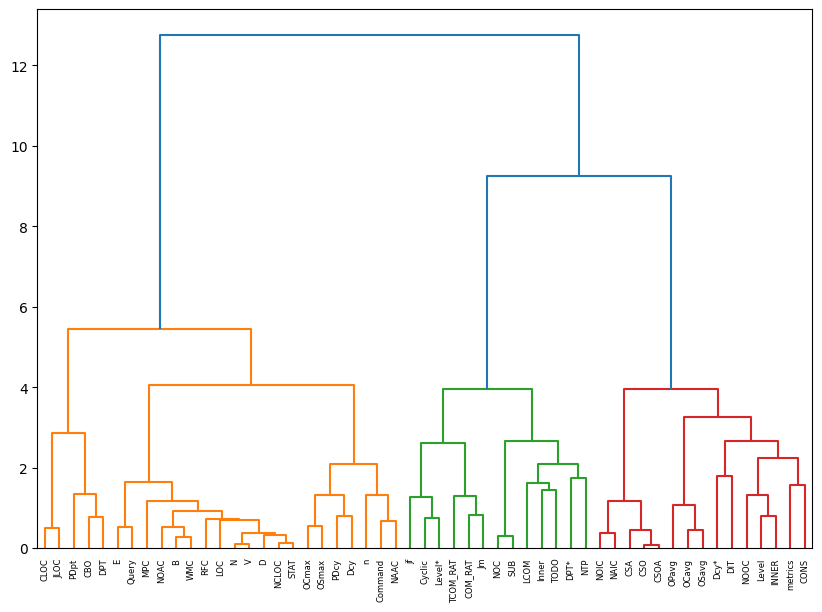

[32  5 14 12  6 27 28 21  4 18 20 29  6  6  6  5 17 23  8  9  3  6 17 16
  6  5  2  1 10 33 24 24 24  9  2 30 13  1 15 12  7 11 10 23 31 22 25 26
 25  8  4  6 19]
33 [27, 26, 20, 8, 1, 4, 40, 18, 19, 28, 41, 3, 36, 2, 38, 23, 16, 9, 52, 10, 7, 45, 17, 30, 46, 47, 5, 6, 11, 35, 44, 0, 29]
['CLOC', 'CBO', 'PDpt', 'E', 'B', 'D', 'MPC', 'OCmax', 'PDcy', 'Command', 'n', 'Cyclic', 'jf', 'COM_RAT', 'Jm', 'TCOM_RAT', 'NOC', 'Inner', 'TODO', 'LCOM', 'DPT*', 'NTP', 'NOIC', 'CSA', 'OCavg', 'OPavg', 'Dcy*', 'DIT', 'Level', 'INNER', 'NOOC', 'metrics', 'CONS']


IndexError: index 40 is out of bounds for axis 1 with size 40

In [31]:
df = pd.read_excel('./data.xlsx')
for key in ['CC', 'MC', 'CC-1', 'MC-1']:
    df[key] = pd.to_numeric(df[key].str.split('%', expand=True)[0]) / 100
for key in ['metrics']:
    _cat = df[key].astype('category').cat
    print(_cat.categories)
    df[key] = _cat.codes
df_check = df.isnull().any(axis=1)
df = df.fillna(-1)
corr = df[FEATURE_COLUMNS].corr()
distance_matrix = 1 - corr
Z = sch.linkage(distance_matrix, method='ward')
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=corr.columns)
plt.show()
max_d = 0.8
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

_ids_list = []
_names_list = []
for _idx in range(max(clusters)):
    _ids = np.where(clusters == _idx+1)[0][0]
    _ids_list.append(_ids)
    _names_list.append(corr.columns[_ids])
print(len(_ids_list), _ids_list)
print(_names_list)
train_x = train_x[:, _ids_list]

In [39]:
pca = PCA(n_components=40)
train_x = pca.fit_transform(train_x)
print(train_x.shape)

(372, 40)


In [63]:
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.4, random_state=42)

val_x, test_x, val_y, test_y = train_test_split(
    val_x, val_y, test_size=0.5, random_state=42)

print(train_x.shape, val_x.shape, test_x.shape)

(620, 53) (207, 53) (207, 53)


In [64]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, labels = self.data[idx], self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return data, labels

class Block1D(nn.Module):
    def __init__(self, in_channels):
        super(Block1D, self).__init__()
        self.layer1 = nn.Linear(in_channels, in_channels)
        self.norm1 = nn.BatchNorm1d(in_channels)
        self.layer2 = nn.Linear(in_channels, in_channels)
        self.norm2 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        identity = x
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = x + identity
        x = self.relu(x)
        return x

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.block1 = Block1D(128)
        self.layer3 = nn.Linear(128, 64)
        self.block2 = Block1D(64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.block2(x)
        x = self.output(x)
        return x

In [65]:
batch_size = 32
class AddNoise:
    def __init__(self, p=0.5, noise_scale=0.05):
        self.p = p
        self.noise_scale = noise_scale
    def __call__(self, x):
        if torch.rand(1).item() < self.p:
            x = x + torch.randn_like(x) * self.noise_scale
        return x

class RandomZero:
    def __init__(self, feat_drop_prob=0.2):
        self.feat_drop_prob = feat_drop_prob
    def __call__(self, x):
        mask = torch.rand_like(x) > self.feat_drop_prob
        x *= mask.float()
        return x
        
transform = transforms.Compose([
    # AddNoise(0.8, 0.02),
    # RandomZero(0.05)
])
train_dataset = CustomDataset(train_x, train_y, transform)
val_dataset = CustomDataset(val_x, val_y)
test_dataset = CustomDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_features = len(train_dataset[0][0])
model = BinaryClassifier(input_dim=num_features)
criterion = nn.BCEWithLogitsLoss()  # 内置Sigmoid + 交叉熵
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BinaryClassifier(
  (layer1): Linear(in_features=53, out_features=128, bias=True)
  (block1): Block1D(
    (layer1): Linear(in_features=128, out_features=128, bias=True)
    (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (block2): Block1D(
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [66]:
bast_acc = 0.0
best_epoch = 0
best_state_dict = None
last_state_dict = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        mask = torch.rand_like(inputs) < 0.3
        _idx = torch.randperm(len(inputs))
        _id_mask = torch.rand_like(_idx.float()) > 0.6
        _idx[_id_mask] = torch.arange(len(inputs))[_id_mask]
        inputs[mask] = inputs[_idx][mask]
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    # 计算训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    
    # 验证阶段
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    if bast_acc < test_acc:
        best_state_dict = deepcopy(model.state_dict())
        bast_acc = test_acc
        best_epoch = epoch+1
    last_state_dict = deepcopy(model.state_dict())
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Loss: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f'Epoch: {best_epoch} | best acc: {bast_acc:.4f}')

Epoch 1/400
Train Loss: 0.6302 | Train Loss: 0.6306 | Test Loss: 0.5960 | Test Acc: 0.7101
Epoch 2/400
Train Loss: 0.5559 | Train Loss: 0.6952 | Test Loss: 0.4871 | Test Acc: 0.7681
Epoch 3/400
Train Loss: 0.5105 | Train Loss: 0.7355 | Test Loss: 0.4571 | Test Acc: 0.7826
Epoch 4/400
Train Loss: 0.5043 | Train Loss: 0.7484 | Test Loss: 0.4620 | Test Acc: 0.8116
Epoch 5/400
Train Loss: 0.5100 | Train Loss: 0.7500 | Test Loss: 0.4751 | Test Acc: 0.7923
Epoch 6/400
Train Loss: 0.4975 | Train Loss: 0.7452 | Test Loss: 0.4689 | Test Acc: 0.7681
Epoch 7/400
Train Loss: 0.4946 | Train Loss: 0.7403 | Test Loss: 0.4800 | Test Acc: 0.7729
Epoch 8/400
Train Loss: 0.4998 | Train Loss: 0.7403 | Test Loss: 0.4657 | Test Acc: 0.7826
Epoch 9/400
Train Loss: 0.4922 | Train Loss: 0.7484 | Test Loss: 0.4850 | Test Acc: 0.7778
Epoch 10/400
Train Loss: 0.4764 | Train Loss: 0.7677 | Test Loss: 0.4615 | Test Acc: 0.7826
Epoch 11/400
Train Loss: 0.4731 | Train Loss: 0.7677 | Test Loss: 0.4698 | Test Acc: 0.77

In [67]:
model.load_state_dict(best_state_dict) # best_state_dict last_state_dict
model.eval()
test_loss = 0.0
correct = 0
total = 0
y_target = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        y_target.extend(labels.view(-1).cpu().numpy())
        outputs = model(inputs)
        y_pred.extend(torch.nn.functional.sigmoid(outputs).view(-1).cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

y_target = np.array(y_target)
y_pred = np.array(y_pred)
test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.6156 | Test Acc: 0.7053


In [68]:
metrics = {
    '准确率': accuracy_score(y_target, y_pred > 0.5),
    '精确率': precision_score(y_target, y_pred > 0.5),
    '召回率': recall_score(y_target, y_pred > 0.5),
    'F1分数': f1_score(y_target, y_pred > 0.5),
    'AUC': roc_auc_score(y_target, y_pred)
}
print(metrics)

{'准确率': 0.7053140096618358, '精确率': 0.5384615384615384, '召回率': 0.4307692307692308, 'F1分数': 0.47863247863247865, 'AUC': 0.7380281690140846}


In [69]:
confusion_matrix(y_target, y_pred > 0.5)

array([[118,  24],
       [ 37,  28]], dtype=int64)

In [70]:
print(
    classification_report(y_target, y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       142
         1.0       0.54      0.43      0.48        65

    accuracy                           0.71       207
   macro avg       0.65      0.63      0.64       207
weighted avg       0.69      0.71      0.70       207

